# Project 3 Subreddits Classification - r/netflix vs r/hulu

## Problem Statement

Working as a data scientist in Netflix, I am tasked to help the content team identify what are some of the series or films that our audience seems to be interested in to maintain customer satisfaction. Looking at what Netflix users and Hulu users are posting about on reddit could help to give an idea about which Netflix content is popular and if there are any content Hulu is popular for which Netflix could improve on.

## Executive Summary

What Netflix contents are doing great and which ones needs improvement? This is the big question we are trying to answer. 

In this project, I will look at 2 subreddit posts, [r/Netflix](https://www.reddit.com/r/netflix/) and one of Netflix's competitors [r/Hulu](https://www.reddit.com/r/Hulu/). Netflix and Hulu are very similar in that sense they are both streaming platforms for shows. To answer the question above, I will have to look past the similarities and find the differences which are the titles to the different shows they house in their libraries. Using these show titles, I can then find out which contents Netflix and Hulu are known for and tackle the question above.

To look at the top different posts in each subreddit, I have developed a classification model to predict which subreddit some unseen posts belongs to. Models were evaluated and finally the final model selected was the Multinomial Naive Bayes classifier predicting base on 2 word ranges. This model has an accuracy of 66% which is acceptable considering how similar these 2 subreddits are. The misclassifications especially for Netflix is due to the smaller proportion of posts collected from the subreddit compared to Hulu. We can look to improve the model accuracy by scraping more posts for Netflix.

Based on the classification and EDA of film/series titles based on the top words predicted to occur in each subreddits, Netflix does well in what they are known for which is their original series but can improve on the Anime genre which Hulu seems to thrive on. 

### Contents:
- [Data Dictionary](#Data-Dictionary)
- [Data Collection](#Data-Collection)
- [Data Cleaning & EDA](#Data-Cleaning-&-EDA)
- [Preprocessing & Modeling](#Preprocessing-&-Modeling)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

In [428]:
#Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import random
import time
import re
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows',5000)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',10000)
pd.set_option('display.max_colwidth', None)

## Data Dictionary

|Feature|Type|Dataset|<div style="text-align: left">Data</div>|<div style="text-align: left">Description</div>|
|---|---|---|---|---|
|<div style="text-align: left">**all_words**</div>|<div style="text-align: left">*object*</div>|<div style="text-align: left">posts_df</div>|<div style="text-align: left">Combined title and selftext</div>|<div style="text-align: left">Each individual posts, which consists of the title and selftext, from the subreddits of r/netflix and r/hulu</div>|
|<div style="text-align: left">**target**</div>|<div style="text-align: left">*integer*</div>|<div style="text-align: left">posts_df</div>|<div style="text-align: left">0 = r/Hulu<br>1 = r/netflix</div>|<div style="text-align: left">Target variable to identify which subreddit the post belongs to</div>|
|<div style="text-align: left">**length_all_words**</div>|<div style="text-align: left">*integer*</div>|<div style="text-align: left">posts_df</div>|<div style="text-align: left">range 1 to 579</div>|<div style="text-align: left">The number of words in each posts(length of each posts)</div>|

## Data Collection

#### Requests for Netflix

In [ ]:
url_netflix = 'https://www.reddit.com/r/netflix.json'

In [ ]:
res_netflix = requests.get(url_netflix,
                           headers={'User-agent': 'Becks Inc 1.0'})

In [ ]:
res_netflix.status_code

###### Create a netflix dataframe ######

In [ ]:
res_netflix.text

In [ ]:
netflix_dict = res_netflix.json(
)  # to create data that is accesible for python
print(netflix_dict)

In [ ]:
netflix_dict.keys()

In [ ]:
netflix_dict['data']

In [ ]:
netflix_dict['data'].keys()

We are interested in "children" for the text and "after" for scraping.

We will first grab all the posts which is under "children"

In [ ]:
netflix_dict['data']['children']

#essentially want to see in the subreddit, the selftext and title which is in the data of children

In [ ]:
netflix_posts = [p['data'] for p in netflix_dict['data']['children']
                 ]  #to get all the post's data

In [ ]:
len(netflix_posts)

In [ ]:
pd.DataFrame(netflix_posts).head()

In [ ]:
pd.DataFrame(netflix_posts).to_csv(
    'netflix_posts.csv')  #want to save, which is the data you collected.

In [ ]:
res_hulu.status_code

#### Requests for Hulu

Similarly like what we did for r/neflix, we will request and save the posts from r/hulu as well.

In [ ]:
url_hulu = 'https://www.reddit.com/r/hulu.json'

In [ ]:
res_hulu = requests.get(url_hulu, headers={'User-agent': 'Becks Inc 1.0'})

###### Create a Hulu dataframe ######

In [ ]:
hulu_dict = res_hulu.json()  #to create data that is accesible for python
print(hulu_dict)

In [ ]:
hulu_dict.keys()

In [ ]:
hulu_dict['data']['children'][0]

In [ ]:
#similarly, we want all the data of all the posts(children)
hulu_dict['data']['children'][0]['data']

In [ ]:
hulu_posts = [p['data'] for p in hulu_dict['data']['children']]

In [ ]:
len(hulu_posts)  #there are 26 posts on the first page of the first requests

In [ ]:
# create a dataframe of the posts
hulu_posts = pd.DataFrame(hulu_posts)

In [ ]:
hulu_posts.head(1)

In [ ]:
hulu_posts.shape

In [ ]:
hulu_posts.to_csv('hulu_posts.csv')  #save the hulu df

***After saving all the initial posts collected, we will now scrape the r/netflix and r/hulu for more posts.***

In [ ]:
# define a function to loop through pages of subreddits to gather more data, create dataframe and save to csv
def add_subreddit(subreddit_url, subreddit_posts, pages=80):
    posts = []
    after = None

    for a in range(pages):
        if after == None:
            current_url = subreddit_url
        else:
            current_url = subreddit_url + '?after=' + after
        print(current_url)
        res = requests.get(current_url,
                           headers={'User-agent': 'Becks Inc 1.0'})

        if res.status_code != 200:
            print('Status error', res.status_code)
            break

        current_dict = res.json()
        current_posts = [p['data'] for p in current_dict['data']['children']]
        posts.extend(current_posts)
        after = current_dict['data']['after']

        # COMPLETE THE CODE!
        if a > 0:
            prev_posts = pd.read_csv(subreddit_posts + '.csv')
            current_df = pd.DataFrame(current_posts)
            new_df = pd.concat([prev_posts, current_df])
            new_df.to_csv(subreddit_posts + '.csv', index=False)

        else:
            pd.DataFrame(posts).to_csv(
                subreddit_posts + '.csv',
                index=False)  # just to save while doing loop.. in case!

        # generate a random sleep duration to look more 'natural'
        sleep_duration = random.randint(2, 6)
        print(sleep_duration)
        time.sleep(sleep_duration)
        # print number of posts saved
        print(f'a total of {len(posts)} posts were downloaded.')

In [ ]:
add_subreddit(url_netflix, 'netflix_posts')
#to get more posts from netflix, used the default 80 pages

In [ ]:
add_subreddit(url_hulu, 'hulu_posts')
#to get more posts from hulu, used the default 80 pages

## Data Cleaning & EDA

#### Import Netflix dataframe and get the 'subreddit', 'title', 'selftext'.

In [2]:
netflix_df = pd.read_csv('netflix_posts.csv')

In [3]:
netflix_df.shape  # checking how many posts/observations

(1936, 107)

In [4]:
netflix_df.head(1)

approved_at_utc subreddit selftext author_fullname  saved  mod_reason_title  gilded  clicked                                                                                    title link_flair_richtext subreddit_name_prefixed  hidden  pwls link_flair_css_class  downs  top_awarded_type  hide_score       name  quarantine link_flair_text_color  upvote_ratio  author_flair_background_color subreddit_type   ups  total_awards_received                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              media_embed  author_flair_template_id  is_original_content user_reports                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      secure_media  is_reddit_media_domain  is_meta  category                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            secure_media_embed link_flair_text  can_mod_post  score  approved_by author_premium  thumbnail edited  author_flair_css_class author_flair_richtext gildings  content_categories  is_self  mod_note       created link_flair_type  wls  removed_by_category  banned_by author_flair_type     domain  allow_live_comments selftext_html  likes  suggested_sort  banned_at_utc     url_overridden_by_dest  view_count  archived  no_follow  is_crosspostable  pinned  over_18                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Usually such posts in reddit will have moderators who would create posts often to generate more topics. Usually such posts would have the same title and same selftext which would just create more noise in our data. Lets remove if there are such posts.

In [5]:
netflix_df['distinguished'].unique() #check if there is moderator noise

array([nan])

As there apparently isn't any morderator posts in our data, we can then move on to our next steps, which is to only select the relevant columns which are "title", "selftext" and "subreddit".

In [6]:
# only want the relevant columns (subreddit, title selftext)
netflix_df = netflix_df[['title', 'selftext', 'subreddit']]

In [403]:
netflix_df.tail()

title                                                                                                                                                                                                                                                                                                                                                                                                                                    selftext subreddit
1931  Is there any extension to watch netflix with random people?                                                                                                                                                                                                                                                                                     There are few extensions like netflix party but it only allows people with invite codes to watch. I want to watch series with random like-minded people   netflix
1932                                       Cant Download Anything                                                            So we have a netflix plan that only allows us to have 1 device with downloaded content, the device that had shows downloaded on it was a computer. recently that computers hard drive failed, meaning we cant get on the computer, this also means we cant delete the shows that were downloaded on netflix, so we cant download netflix on any other devices. Need help, thanks   netflix
1933                                                NEW SUBREDDIT                                                                                                                                                                                                                                                     Hi guys I decided to make a subreddit for the Netflix hit movie The Princess Switch, and I just wanted to get the word out so If people want to talk about this amazing movie they can.   netflix
1934                                                       Help?!                                                                                                                                                                           I tried to watch vikings in netflix on my laptop, but it just loads and loads and loads... Any other movie or serie works, but vikings dont. Why, is this because i have bad internet connection or what. Sry my bad english, hope you can understand my problem.   netflix
1935                                     Unable to access profile  Me and my girlfriend share a netflix account on a family plan. I use my ipad mostly and my phone ocassionally. Currently I am unable to access the profile me and my girlfriend use because netflix is prompting me to enter a pin code. Afaik we don't have a pincode that we use for our profile. I can't click our profile because I am stuck at enter pincode. Can anybody provide any help? Any advice would be appreciated thank you   netflix

In [8]:
netflix_df.shape

(1936, 3)

#### Import Hulu dataframe and get the 'subreddit', 'title', 'selftext'.

In [9]:
hulu_df = pd.read_csv('hulu_posts.csv')

In [10]:
hulu_df.shape

(1963, 114)

In [11]:
hulu_df.head(1)

approved_at_utc subreddit selftext author_fullname  saved  mod_reason_title  gilded  clicked                                                       title link_flair_richtext subreddit_name_prefixed  hidden  pwls link_flair_css_class  downs  thumbnail_height  top_awarded_type  hide_score       name  quarantine link_flair_text_color  upvote_ratio  author_flair_background_color subreddit_type  ups  total_awards_received media_embed  thumbnail_width author_flair_template_id  is_original_content user_reports secure_media  is_reddit_media_domain  is_meta  category secure_media_embed link_flair_text  can_mod_post  score  approved_by author_premium                                                                         thumbnail edited author_flair_css_class author_flair_richtext gildings post_hint  content_categories  is_self  mod_note       created link_flair_type  wls  removed_by_category  banned_by author_flair_type        domain  allow_live_comments selftext_html  likes  suggested_sort  banned_at_utc                                                                                        url_overridden_by_dest  view_count  archived  no_follow  is_crosspostable  pinned  over_18                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              preview all_awardings awarders  media_only                link_flair_template_id  can_gild  spoiler  locked author_flair_text treatment_tags  visited  removed_by  num_reports distinguished subreddit_id  mod_reason_by  removal_reason link_flair_background_color      id  is_robot_indexable  report_reasons author  discussion_type  num_comments  send_replies whitelist_status  contest_mode mod_reports author_patreon_flair author_flair_text_color                                                                  permalink parent_whitelist_status  stickied                                                                                                           url  subreddit_subscribers   created_utc  num_crossposts media  is_video media_metadata author_cakeday is_gallery gallery_data crosspost_parent_list crosspost_parent
0              NaN      Hulu      NaN        t2_x2ai7  False               NaN       0    False  Hulu To Hike Live TV Subscription Price By 18% In December                  []                  r/Hulu   False     6                  NaN      0              94.0               NaN       False  t3_jve0bp       False                 light          0.97                            NaN         public  225                      0          {}            140.0                      NaN                False           []          NaN                   False    False       NaN                 {}      MegaThread         False    225          NaN        

In [12]:
# similarly, only want the relevant columns (subreddit, title selftext)
hulu_df = hulu_df[['title', 'selftext', 'subreddit']]

In [404]:
hulu_df.tail()

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           selftext subreddit
1958                                    Hulu on Switch keeps crashing                                                                                                                                                                                                                                                                                                                                                                                                          Has anyone else had this problem? After ad breaks, Hulu crashes and all it says is “The software was closed because an error occurred.”\nI just wanna watch Fire Force :(      Hulu
1959                               Unable to Watch From Start on Roku                                                                                    In the past few weeks I’ve seen issues where even if I have a show recorded or have the option to “Watch from start” it doesn’t work.  It will rewind about 20 minutes but not to the start if it’s longer than that.  This worked normally prior to a couple weeks ago.\n\nThis only seems to happen on my Roku.  I’ve watched the same show or sports on the Hulu app on a tablet or PS4 and it lets me start at the beginning.  It appears to be only on the Roku.  Anyone else seeing this?      Hulu
1960                              Hulu starting at the end of episode                                                                                                                                                                                                                                                                                                                                                                 For some reason when I’m watching a show on Hulu on my Rocky, the next episodes starts about 3/4 of the way through the next episode and I have to rewind. Does anyone know why that’s happening or how to fix it?      Hulu
1961  What causes some episodes of a show to have ads and others not?                                                                                                                                                                                                                                                                   For example, American Dad, I've been watching through it, and some of the episodes have no ads at all, then others have 3-4 ad breaks, include ones where there is a minute of ads before the opening and another minute after.\n\nSo is the ad placement random or do some episodes of shows just not have ads?      Hulu
1962            Subscribed and Paid, Hulu won't let me watch anything  So, I have a Hulu subscription through Spotify because I did the Spotify premium student deal. I've had it for a while now and never had an issue. I'm trying to get on right now and it won't let me, even though I am logged in. If I go to my account, it says that my subscription is through Spotify and gives no indication that anything would be wrong, but when I try to browse any shows or anything, I get the screen that says to start watching and then offers several free trials. I don't need a free trial, I have a subscription and pay for it, I'm at a loss.      Hulu

In [14]:
# Combine the 2 subreddits
posts_df = pd.concat([netflix_df, hulu_df])

In [15]:
posts_df['subreddit'].value_counts() 
#there is quite even proportion of Hulu and netflix posts and there are no other posts other than netflix and hulu

Hulu       1963
netflix    1936
Name: subreddit, dtype: int64

In [16]:
posts_df['subreddit'].value_counts(normalize=True) #there is quite a balance between the 2 classes

Hulu       0.503462
netflix    0.496538
Name: subreddit, dtype: float64

There are altogether 3899 posts, 1936 of which are netflix posts and the rests are hulu. The data proportional balance between the 2 classes is considered quite balance.

In [17]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3899 entries, 0 to 1962
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      3899 non-null   object
 1   selftext   2974 non-null   object
 2   subreddit  3899 non-null   object
dtypes: object(3)
memory usage: 121.8+ KB


In [18]:
posts_df.tail()

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           selftext subreddit
1958                                    Hulu on Switch keeps crashing                                                                                                                                                                                                                                                                                                                                                                                                          Has anyone else had this problem? After ad breaks, Hulu crashes and all it says is “The software was closed because an error occurred.”\nI just wanna watch Fire Force :(      Hulu
1959                               Unable to Watch From Start on Roku                                                                                    In the past few weeks I’ve seen issues where even if I have a show recorded or have the option to “Watch from start” it doesn’t work.  It will rewind about 20 minutes but not to the start if it’s longer than that.  This worked normally prior to a couple weeks ago.\n\nThis only seems to happen on my Roku.  I’ve watched the same show or sports on the Hulu app on a tablet or PS4 and it lets me start at the beginning.  It appears to be only on the Roku.  Anyone else seeing this?      Hulu
1960                              Hulu starting at the end of episode                                                                                                                                                                                                                                                                                                                                                                 For some reason when I’m watching a show on Hulu on my Rocky, the next episodes starts about 3/4 of the way through the next episode and I have to rewind. Does anyone know why that’s happening or how to fix it?      Hulu
1961  What causes some episodes of a show to have ads and others not?                                                                                                                                                                                                                                                                   For example, American Dad, I've been watching through it, and some of the episodes have no ads at all, then others have 3-4 ad breaks, include ones where there is a minute of ads before the opening and another minute after.\n\nSo is the ad placement random or do some episodes of shows just not have ads?      Hulu
1962            Subscribed and Paid, Hulu won't let me watch anything  So, I have a Hulu subscription through Spotify because I did the Spotify premium student deal. I've had it for a while now and never had an issue. I'm trying to get on right now and it won't let me, even though I am logged in. If I go to my account, it says that my subscription is through Spotify and gives no indication that anything would be wrong, but when I try to browse any shows or anything, I get the screen that says to start watching and then offers several free trials. I don't need a free trial, I have a subscription and pay for it, I'm at a loss.      Hulu

It seems that the indexes are duplicated and needs to be reset, since there are 3899 posts but the last index is 1962, this is due to the concatenation.

In [19]:
posts_df.reset_index(inplace=True, drop=True) 

In [20]:
posts_df.tail()

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           selftext subreddit
3894                                    Hulu on Switch keeps crashing                                                                                                                                                                                                                                                                                                                                                                                                          Has anyone else had this problem? After ad breaks, Hulu crashes and all it says is “The software was closed because an error occurred.”\nI just wanna watch Fire Force :(      Hulu
3895                               Unable to Watch From Start on Roku                                                                                    In the past few weeks I’ve seen issues where even if I have a show recorded or have the option to “Watch from start” it doesn’t work.  It will rewind about 20 minutes but not to the start if it’s longer than that.  This worked normally prior to a couple weeks ago.\n\nThis only seems to happen on my Roku.  I’ve watched the same show or sports on the Hulu app on a tablet or PS4 and it lets me start at the beginning.  It appears to be only on the Roku.  Anyone else seeing this?      Hulu
3896                              Hulu starting at the end of episode                                                                                                                                                                                                                                                                                                                                                                 For some reason when I’m watching a show on Hulu on my Rocky, the next episodes starts about 3/4 of the way through the next episode and I have to rewind. Does anyone know why that’s happening or how to fix it?      Hulu
3897  What causes some episodes of a show to have ads and others not?                                                                                                                                                                                                                                                                   For example, American Dad, I've been watching through it, and some of the episodes have no ads at all, then others have 3-4 ad breaks, include ones where there is a minute of ads before the opening and another minute after.\n\nSo is the ad placement random or do some episodes of shows just not have ads?      Hulu
3898            Subscribed and Paid, Hulu won't let me watch anything  So, I have a Hulu subscription through Spotify because I did the Spotify premium student deal. I've had it for a while now and never had an issue. I'm trying to get on right now and it won't let me, even though I am logged in. If I go to my account, it says that my subscription is through Spotify and gives no indication that anything would be wrong, but when I try to browse any shows or anything, I get the screen that says to start watching and then offers several free trials. I don't need a free trial, I have a subscription and pay for it, I'm at a loss.      Hulu

#### Data Cleaning

In [21]:
# check for missing values
posts_df.isnull().sum()

title          0
selftext     925
subreddit      0
dtype: int64

Let us check the proportion of the number of missing values in "selftext" that is in r/netflix and r/hulu.

In [22]:
posts_df['selftext'].loc[posts_df['subreddit'] == 'netflix'].isnull().sum()/posts_df.shape[0]

0.15747627596819697

In [23]:
posts_df['selftext'].loc[posts_df['subreddit'] == 'Hulu'].isnull().sum()/posts_df.shape[0]

0.07976404206206719

There is quite a substantial amount of missing values in both the classes for "selftext". Since I am going to combine the "selftext" and "title" later on to get all the words, the missing values shall be filled with blank space.

In [24]:
posts_df['selftext'] = posts_df['selftext'].fillna(' ')

In [25]:
posts_df.isnull().sum()

#no more missing values

title        0
selftext     0
subreddit    0
dtype: int64

Combining the "title" and "selftext" column to get "all words". The "title" and "selftext" columns can then be dropped.

In [26]:
# create a column to get all words
posts_df['all_words'] = posts_df['title'] + ' ' + posts_df['selftext']

In [27]:
posts_df.isnull().sum() 

title        0
selftext     0
subreddit    0
all_words    0
dtype: int64

In [28]:
posts_df.drop(columns=['title', 'selftext'], inplace=True)

In [29]:
posts_df.head(1) #checked that column was created and dropped irrelevant columns

subreddit                                                                                  all_words
0   netflix  Netflix now allows you to remove a movie/series from the "continue watching" row! [All]

Now, lets map the "target" 1 for netflix and 0 for hulu. Dropping the subreddit column.

In [30]:
posts_df['target'] = posts_df['subreddit'].map({'netflix': 1, 'Hulu': 0})

In [31]:
posts_df.drop(columns=['subreddit'], inplace=True)

In [32]:
posts_df.head(2) # check that netflix mapped correctly

all_words  target
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Netflix now allows you to remove a movie/series from the "continue watching" row! [All]         1
1  Hi we're Mark, Zach and Broden from Aunty Donna, we got our first big break on reddit. We've just released our first tv series on Netflix. AMA. Hello everyone, 8 years ago we woke up one day and found one of our youtube videos had gone crazy on r/Videos. 8 year later thanks to lots of support form the reddit community we got our shot at our own TV show, Aunty Donna's Big Ol' House of Fun on Netflix.\n\nWe’re gonna be answering anything for the next hour or so. Answering today will be the aforementioned three performers, as well as head writer Sam Lingham, film maker Max Miller and composer Tom Armstrong.\n\nIf you don’t know who we are here's a little introductory playlist of our work so far: https://www.youtube.com/playlist?list=PLEzN-y0ZMgptSc7jzquvG0XrdfOnSMAQS\n\n\nProof: \n\n - https://i.redd.it/ryyg4p9amhz51.jpg\n - https://i.redd.it/o982fwqcmhz51.jpg\n - https://i.redd.it/2dn3dpwemhz51.jpg\n\nEDIT 1: Okay, Bro, Mark and I (Zach) gotta sign off for a bit to go record a pod. But the BTS boys might stick around for a little bit. Pls keep asking etc and we'll try to jump back on and answer a few more in the next day or so. Thanks for all your wonderful questions and support! Hope you enjoy/ are enjoying the show!       1

In [33]:
posts_df.tail(2) # check that hulu mapped correctly

all_words  target
3897                                                                                                                                                                                                                                                         What causes some episodes of a show to have ads and others not? For example, American Dad, I've been watching through it, and some of the episodes have no ads at all, then others have 3-4 ad breaks, include ones where there is a minute of ads before the opening and another minute after.\n\nSo is the ad placement random or do some episodes of shows just not have ads?       0
3898  Subscribed and Paid, Hulu won't let me watch anything So, I have a Hulu subscription through Spotify because I did the Spotify premium student deal. I've had it for a while now and never had an issue. I'm trying to get on right now and it won't let me, even though I am logged in. If I go to my account, it says that my subscription is through Spotify and gives no indication that anything would be wrong, but when I try to browse any shows or anything, I get the screen that says to start watching and then offers several free trials. I don't need a free trial, I have a subscription and pay for it, I'm at a loss.       0

In [34]:
posts_df['all_words'][0] # need to remove special characters punctuations

'Netflix now allows you to remove a movie/series from the "continue watching" row! [All]  '

In [35]:
posts_df['all_words'].sum() 
# glancing at all the posts, see jpg and png which are images format. There are also urls
# need to remove them

'Netflix now allows you to remove a movie/series from the "continue watching" row! [All]  Hi we\'re Mark, Zach and Broden from Aunty Donna, we got our first big break on reddit. We\'ve just released our first tv series on Netflix. AMA. Hello everyone, 8 years ago we woke up one day and found one of our youtube videos had gone crazy on r/Videos. 8 year later thanks to lots of support form the reddit community we got our shot at our own TV show, Aunty Donna\'s Big Ol\' House of Fun on Netflix.\n\nWe’re gonna be answering anything for the next hour or so. Answering today will be the aforementioned three performers, as well as head writer Sam Lingham, film maker Max Miller and composer Tom Armstrong.\n\nIf you don’t know who we are here\'s a little introductory playlist of our work so far: https://www.youtube.com/playlist?list=PLEzN-y0ZMgptSc7jzquvG0XrdfOnSMAQS\n\n\nProof: \n\n - https://i.redd.it/ryyg4p9amhz51.jpg\n - https://i.redd.it/o982fwqcmhz51.jpg\n - https://i.redd.it/2dn3dpwemhz51

Looking at the posts in general, I can see many punctuations, even some hyperlinks. Create a function to remove the punctuations, hyperlinks, make all words lower case and remove stop words.

In [36]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()

Before creating the function to clean the data, lets create and update stop words. Stopwords created to remove words that occur frequently and therefore would have no value to help classify into classes: Netflix and hulu. Words like "show", "watch", "watching" and "serie" would be common in these classes and should be added to stop words. Further additions can be added to stops after further evaluation.

In [369]:
stops = set(stopwords.words('english'))
stops.update(('netflix','hulu','show','watch','watching','serie','movie','like',
              'episode','season','really','also')) 
# did eda and found many words I considered noise, and updated the stopwords

In [370]:
# can use the .apply() function on pandas series for each value
# decided not to put stopwords here and use the countvectorizer one instead
def clean(post):
    # Remove hyperlinks
    post = re.sub(r'https?:\/\/.*\/\w*', '', post)

    # Make lowercase
    post = post.lower()

    # Remove all punctuations and special characters
    post = re.sub(r"[^a-zA-Z]", " ", post)
    
    # Remove all images
    post = re.sub(r"\b\w{1,3}\b", "", post)
    
    # Split into individual words.
    words = post.split()
    
    # Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # Lemmentize
    post = [lemmatizer.lemmatize(w) for w in meaningful_words]

    return (" ".join(post))

In [371]:
stops

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'episode',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'hulu',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'like',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'movie',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'netflix',
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other'

Apply the clean function defined above to all the posts in the data series.

In [373]:
posts_df['all_words'] = posts_df['all_words'].apply(clean) #apply the clean function to all values in the series

In [374]:
posts_df['all_words'].sum() # check all images, urls, punctuations and special characters are cleared

'settle bandersnatch choose adventure lawsuiterrementari blacksmith devil available rare basque language horror visual treatchristmas prince star want make holiday universe crossoverwont autoplay already watched title finished want wont autoplay finihsed keep sending screen different title back find press play every verry annoying helpbrown dull tint xbox used open colour quite vibrant since last week brown tinge dull effecting xboxs update issue none setting changed since eithercommunity advanced dungeon dragon point watched least time disappeared longer anywheresomething teleparty mobile friend want together want something party teleparty personal computer iphone android something similar phone hoststill dolby vision samsung rather dolby vision content support dolby vision premium significant quality seeing versus someone sony dolby vision thankcanada french option seriously offer spiderman multi verse english spanish russian italian almost language except french come canada prioriti

Checking for duplication and dropping these duplicates in the next few steps. We do not want additional noise that may affect our evaluation later on.

In [375]:
posts_df.shape

(1498, 3)

In [376]:
posts_df[(posts_df.duplicated(subset=['all_words']))] \
                .sort_values(ascending=False, by='all_words') \
                ['all_words']


Series([], Name: all_words, dtype: object)

There seems to be many duplicates of each posts. This is because while scraping for more posts, the loop scraped the same pages twice. Drop these duplicates and leave the last scraped post.

In [377]:
posts_df.drop_duplicates(subset=['all_words'], keep='last', inplace=True)

In [378]:
posts_df.shape

(1498, 3)

In [379]:
(3899-1499)/3899

0.6155424467812259

Dropped around 60% of data which are duplicates. Even though we have dropped 60% worth of data, there is still sufficient amount of data, 1499 posts, left for our model to train on.

#### EDA

Lets check the balance of the dataset between the 2 classes again after dropping the duplicates.

In [408]:
class_proportion = posts_df['target'].value_counts(normalize=True)
class_proportion

0    0.601469
1    0.398531
Name: target, dtype: float64

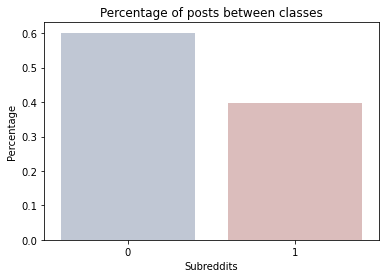

In [427]:
sns.barplot(x=class_proportion.index, y=posts_df['target'].value_counts(normalize=True), palette='vlag')
plt.title('Percentage of posts between classes')
plt.ylabel('Percentage')
plt.xlabel('Subreddits');

There seems to be an unbalanced data weight between the 2 classes now.

**Distribution of posts**

In order to look at the distribution of the length of the posts to see the kind of data there is, the length of each posts needs to be identified.

In [381]:
posts_df['length_all_words'] = [len(x) for x in posts_df['all_words'].str.split(' ')]

In [382]:
posts_df.head(2)[['length_all_words','all_words']]

length_all_words                                                                        all_words
1333                 5                                     settle bandersnatch choose adventure lawsuit
1334                10  errementari blacksmith devil available rare basque language horror visual treat

Plot the distribution of the length of each posts.

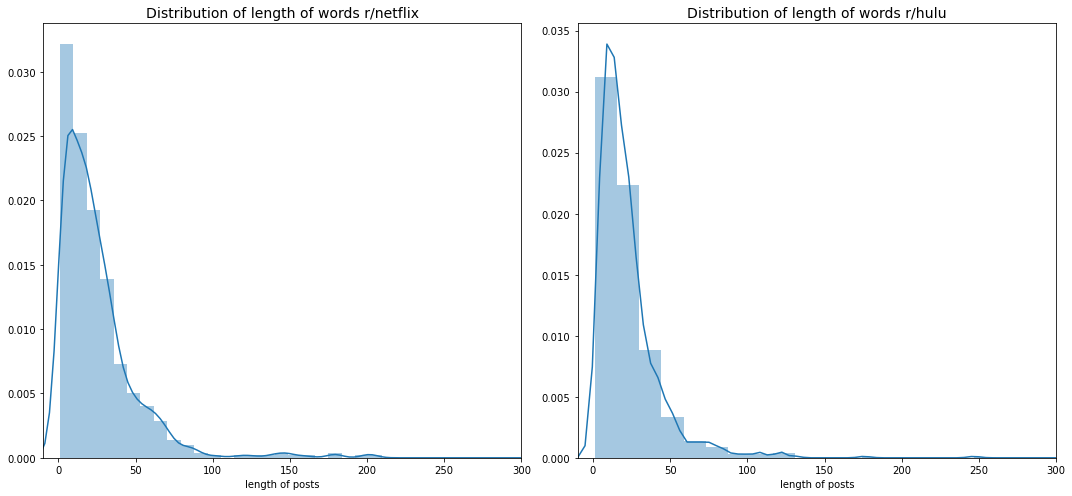

In [383]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7))

sns.distplot(posts_df[posts_df['target']==1]['length_all_words'], ax= ax[0], bins=40)
ax[0].set_xlabel('length of posts')
ax[0].set_xlim(-10,300)
ax[0].set_title('Distribution of length of words r/netflix', fontsize=14)
sns.distplot(posts_df[posts_df['target']==0]['length_all_words'], ax=ax[1], bins=40)
ax[1].set_xlabel('length of posts')
ax[1].set_xlim(-10,300)
ax[1].set_title('Distribution of length of words r/hulu', fontsize=14)

plt.tight_layout()

The length of posts from the subreddits are quite similar. Most of the posts in r/netflix and r/hulu are in the range of 0 to 50 words.

**Frequency and relevancy of words in each subreddit**

###### 1. Word Cloud

In [ ]:
pip install wordcloud

Found help at [stackoverflow - code](https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python) and [stackoverflow - mask](https://amueller.github.io/word_cloud/auto_examples/masked.html) and [word cloud](https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5)

In [384]:
# Import word cloud library
from wordcloud import WordCloud #STOPWORDS
from PIL import Image

In [385]:
# text have to be a str, mask_img is a path
def word_cloud(text, plot_title=None, mask_img=None):

    mask = np.array(Image.open(mask_img))

    wordcloud = WordCloud(
        stopwords=stops,
        mask=mask,
        #scale=7,
        width = 3000,
        height = 2000,
        max_words=500,
        background_color='black',
        colormap='Pastel1',
        random_state=42
    ).generate(text)
    plt.figure(figsize=(16, 16), facecolor='white')
    plt.imshow(wordcloud, interpolation="spline36")
    if plot_title:
        plt.title(plot_title, fontsize=20, pad=20)
    plt.axis("off")
    plt.show()

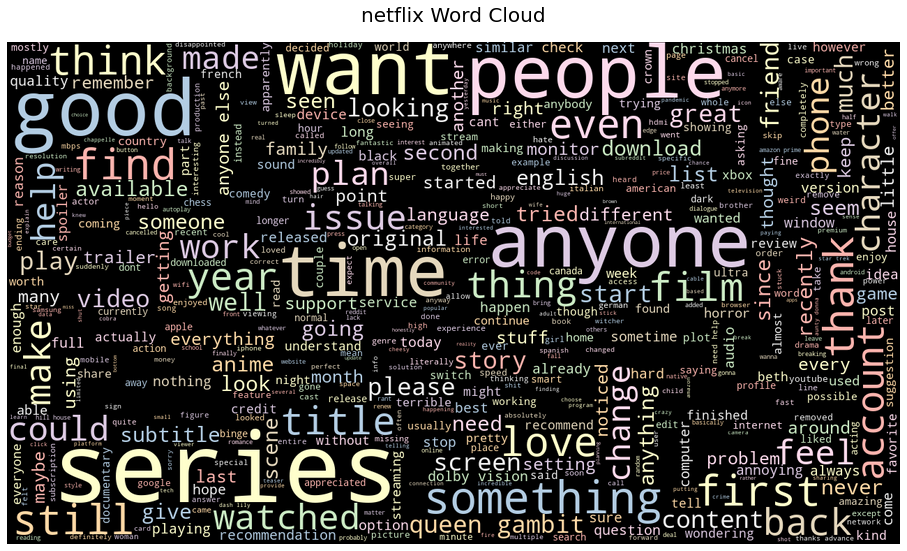

In [386]:
# target 1 is our interest, netflix
word_cloud(str(posts_df[posts_df.target == 1]['all_words']),
           plot_title='netflix Word Cloud',
          mask_img='Images/socialmedia.png')

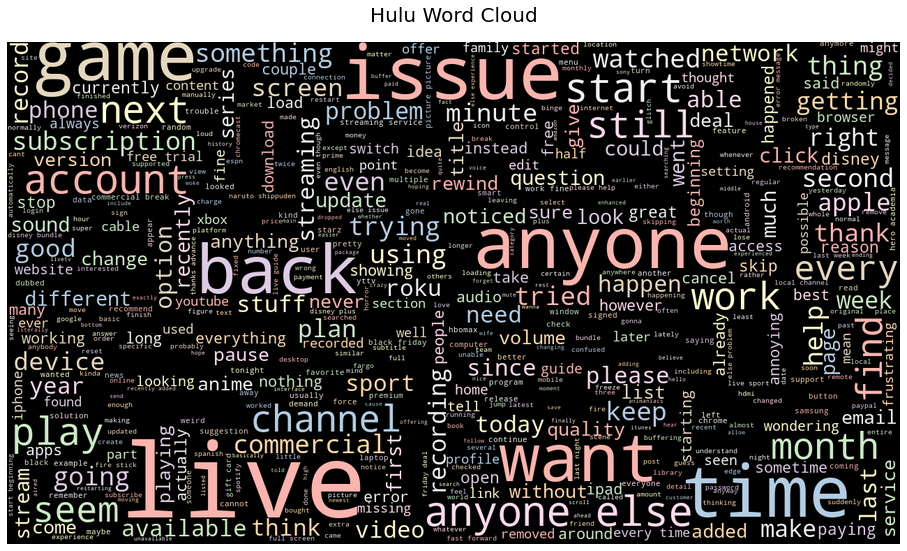

In [387]:
# target 0 is Hulu
word_cloud(str(posts_df[posts_df.target == 0]['all_words']),
           plot_title='Hulu Word Cloud',
           mask_img='Images/socialmedia.png')

At first glance from the word cloud, netflix original series seems to be quite popular. Words like "Queen Gambit which is an original series. Netflix is known for their original content, and this is good that it is popular. 

The most prominent word that stands out is "live" for hulu, hulu has live channels which netflix do not. Hulu offers a bundle which offers access to everything in the Hulu streaming library (basic), plus 65 live and on-demand channels you can watch at home or on-the-go. Another word that caught my attention is "commercial", as hulu offers a commercial free version and a non-commercial free version. Whereas netflix is only a one type subscription, price ranges depending on how many devices you want to have on at one time.

Netflix does not seem to have many complaints regarding their platform. We see words like "good' and 'great' occuring often, and this may be a good sign that customers are satisfied with the contents netflix is offering. Whereas Hulu on the other hand have words like "problem" and "issue".

Although hulu offers live channels, Netflix's direction is not towards live channels[uniqueness](https://www.fool.com/investing/2018/09/26/will-netflix-ever-consider-live-tv.aspx), instead Netflix is known for their original contents and binge watching and therefore, this may not be something we are looking into. We will look further in the different types and genres Netflix and Hulu holds in their library for better comparison later on base on the top words that that highly probable to occur in each individual subreddits.

###### 2. Bar Chart

##### Lets take a look at some frequently used words/features in both subreddits by feature extraction using CountVectorizer and TFidfVectorizer which could be considered relevant in our prediction

In [56]:
# Import the Vectorizers from feature_extraction
# We don't want words that are occuring too often or too rare
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvec = CountVectorizer(max_features=500, stop_words=stops, ngram_range=(2,3))
tfidf = TfidfVectorizer(max_features=500, stop_words=stops, ngram_range=(2,3))

##### a) Netflix features

In [57]:
#Cvec, toarray()/todense()
netflix_words_cvec = cvec.fit_transform(
    posts_df[posts_df['target'] == 1].all_words)

netflix_vocab_cvec = pd.DataFrame(netflix_words_cvec.toarray(),
                                  columns=cvec.get_feature_names())

netflix_vocab_cveccount = netflix_vocab_cvec.sum().sort_values(ascending=False)
netflix_vocab_cveccount

queen gambit                   41
anyone know                    27
anyone else                    27
dolby vision                   25
feel like                      18
movie series                   11
would like                     10
need help                      10
thanks advance                  9
title say                       8
amazon prime                    8
hill house                      8
first episode                   8
look like                       8
star trek                       7
dash lily                       7
aunty donna                     7
anybody know                    7
something like                  7
haunting manor                  6
help find                       6
true crime                      6
different country               6
anything else                   6
gift card                       6
seems like                      6
second season                   6
really good                     6
money heist                     6
please know   

In [58]:
# tfidf
# how relevant a word is to a document in a collection of documents
# by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents
netflix_words_tfidf = tfidf.fit_transform(
    posts_df[posts_df['target'] == 1].all_words)

netflix_vocab_tfidf = pd.DataFrame(netflix_words_tfidf.toarray(),
                                   columns=tfidf.get_feature_names())

netflix_vocab_tfidfcount = netflix_vocab_tfidf.sum().sort_values(ascending=False)
netflix_vocab_tfidfcount

queen gambit                   20.292798
anyone else                    11.858599
anyone know                    10.176454
dolby vision                    6.828742
feel like                       6.438813
official trailer                5.671772
first episode                   5.137085
crown season                    5.000000
movie series                    4.877144
aunty donna                     4.487263
money heist                     4.214138
need help                       4.213109
would like                      4.195808
dash lily                       4.116168
something like                  3.843060
title say                       3.818529
please help                     3.801960
emily paris                     3.727957
look like                       3.701943
thanks advance                  3.560988
movie like                      3.483070
coming december                 3.399921
anybody know                    3.330657
umbrella academy                3.323966
tiger king      

##### a) Hulu features

In [59]:
#Cvec, toarray()/todense()
hulu_words_cvec = cvec.fit_transform(
    posts_df[posts_df['target'] == 0].all_words)

hulu_vocab_cvec = pd.DataFrame(hulu_words_cvec.toarray(),
                               columns=cvec.get_feature_names())

hulu_vocab_cveccount = hulu_vocab_cvec.sum().sort_values(ascending=False)
hulu_vocab_cveccount

anyone else                        114
next episode                        58
anyone know                         51
every time                          27
free trial                          24
streaming service                   24
gift card                           23
black friday                        20
episode start                       20
work fine                           19
picture picture                     19
naruto shippuden                    19
hero academia                       19
commercial break                    19
fast forward                        18
disney plus                         18
else problem                        18
else issue                          18
even though                         17
seems like                          17
anyone else problem                 17
live sport                          17
disney bundle                       16
anyone else issue                   15
friday deal                         13
every episode            

In [60]:
# tfidf
hulu_words_tfidf = tfidf.fit_transform(
    posts_df[posts_df['target'] == 0].all_words)

hulu_vocab_tfidf = pd.DataFrame(hulu_words_tfidf.toarray(),
                                   columns=tfidf.get_feature_names())

hulu_vocab_tfidfcount = hulu_vocab_tfidf.sum().sort_values(ascending=False)
hulu_vocab_tfidfcount

anyone else                        36.650499
anyone know                        27.389763
next episode                       15.467754
hero academia                      11.890391
streaming service                  11.309644
free trial                         11.059896
naruto shippuden                   10.582891
every time                         10.252680
work fine                           8.913764
picture picture                     8.278828
black friday                        7.830326
even though                         7.423287
else problem                        7.398223
disney plus                         7.359524
seems like                          7.318454
else issue                          7.285194
please help                         7.089693
want know                           7.029361
anyone else problem                 6.966033
fast forward                        6.742475
gift card                           6.538728
anyone else issue                   6.342411
episode st

In [61]:
0.05*500 # take the top 5% of frequently occuring/ relevant features

25.0

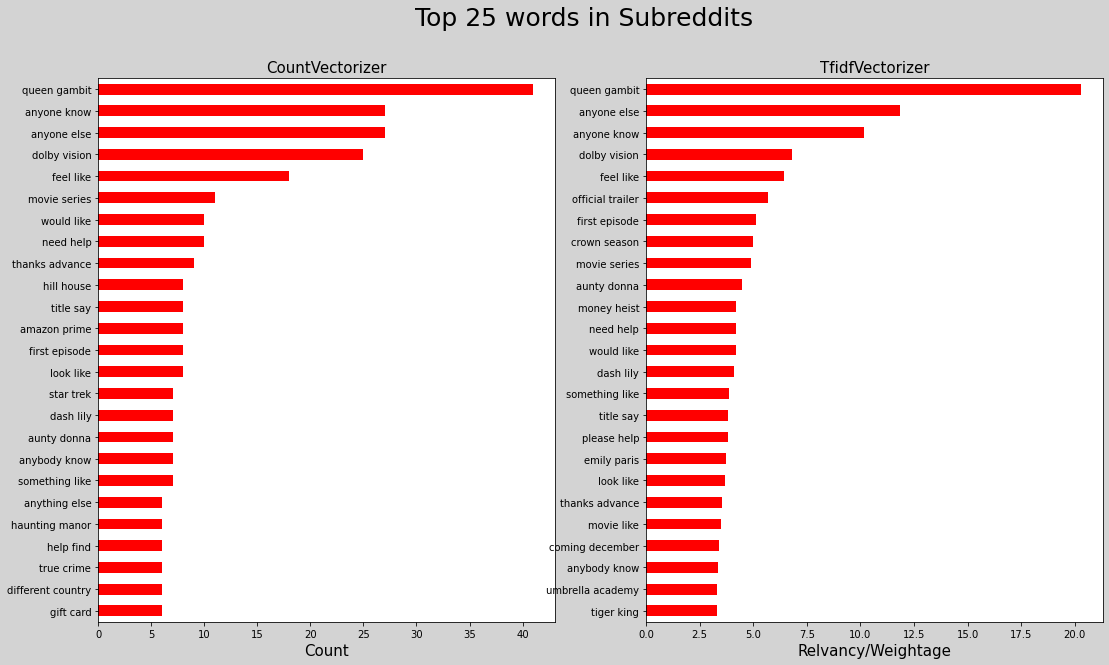

In [186]:
# plt bar graph to visualize top 30 words

#fig, axes = plt.subplots(nrows=1, ncols=2)
#df[["a","b"]].plot(ax=axes[0], kind='bar')
#df[["c", "d"]].plot(ax=axes[1], kind='bar');

fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=(18, 10),
                       facecolor='lightgrey')
fig.suptitle("Top 25 words in Subreddits", fontsize=25)

netflix_vocab_cveccount.head(25).sort_values().plot(
    ax=ax[0],
    kind='barh',
    color='red',)
ax[0].set_xlabel('Count', fontsize=15, c="black")
ax[0].set_title('CountVectorizer', fontsize=15)

netflix_vocab_tfidfcount.head(25).sort_values().plot(ax=ax[1],
                                                     kind='barh',
                                                     color='red')
ax[1].set_xlabel('Relvancy/Weightage', fontsize=15, c="black")
ax[1].set_title('TfidfVectorizer', fontsize=15)

plt.show()

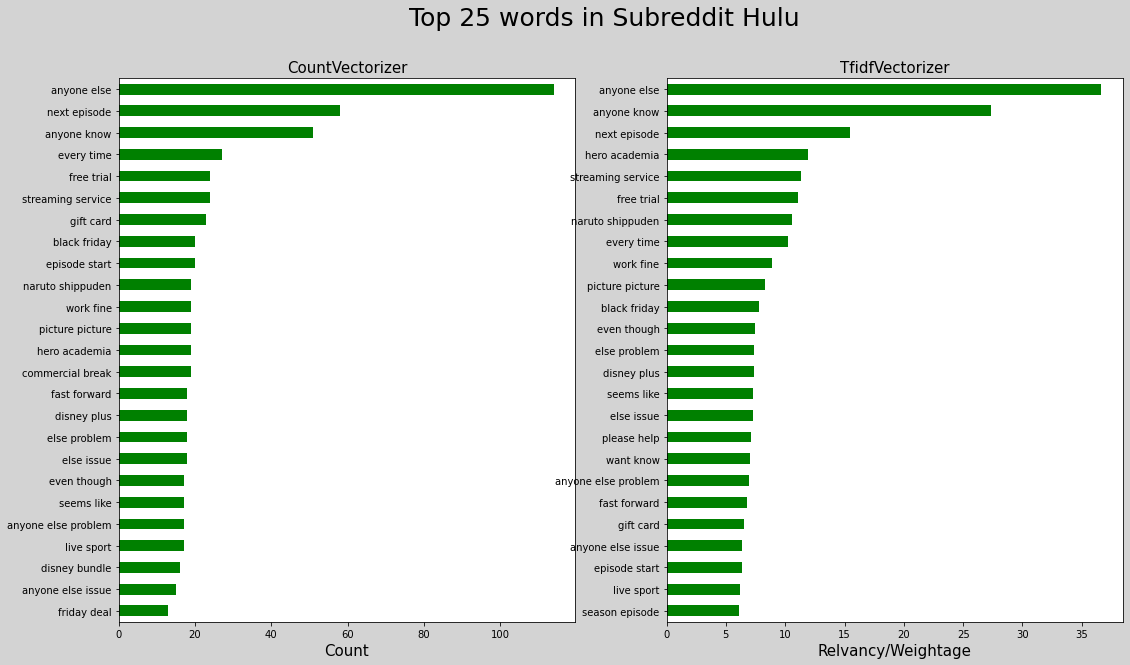

In [63]:
# plt bar graph to visualize top 30 words

fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=(18, 10),
                       facecolor='lightgrey')
fig.suptitle("Top 25 words in Subreddit Hulu", fontsize=25)

hulu_vocab_cveccount.head(25).sort_values().plot(
    ax=ax[0],
    kind='barh',
    color='green',
)
ax[0].set_xlabel('Count', fontsize=15, c="black")
ax[0].set_title('CountVectorizer', fontsize=15)
hulu_vocab_tfidfcount.head(25).sort_values().plot(ax=ax[1],
                                                  kind='barh',
                                                  color='green')
ax[1].set_xlabel('Relvancy/Weightage', fontsize=15, c="black")
ax[1].set_title('TfidfVectorizer', fontsize=15)

plt.show()

From the bar charts, it is clear that the original series, drama series and even supernatural/horror series are popular in Netflix from the show titles seen. However what we see lacking in r/Netflix that is apparent in r/Hulu are anime series. This will be further discussed below.

***However, a thing to note is that from the word cloud and bar chart, we can see that the words in both netflix and hulu are very similar. This therefore may lead to a higher misclassification of words. This will be further elaborated once we evaluate our models.***

## Preprocessing & Modeling

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [65]:
# Assign X and y values

X = posts_df['all_words']
y = posts_df['target']

In [66]:
# train_test_split

X_split, X_test, y_split, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

Creating a test dataset to test our final model and save it to a csv file.

In [67]:
posts_df_test = pd.DataFrame(data=X_test, columns=['all_words'])

In [68]:
posts_df_test['target'] = y_test

In [69]:
posts_df_test.head()

all_words  target
1844                                                                     seeing icon hello television vizio spec support dolby vision looking ultra section seeing ultra dolby vision title seen missing something       1
3057                                                                                                                                                                                greta premiere friday november       0
1663                                                                                                                       ever kid would heard anyone really talk kid much adult show wanna would year show movie       1
3262  naruto shippuden episode pretty anime really enjoying naruto series first time friend major recommended clearly enjoying episode subtitled episode really interested without english audio back rest episode       0
1333                                                                                                                                                                  settle bandersnatch choose adventure lawsuit       1

In [212]:
posts_df_test.shape

(375, 2)

In [211]:
posts_df_test.to_csv('../project_3/test files/test.csv', index=False)

Train-val split will be done to train and validate the models and fine tune them to pick the best model.

In [71]:
X_split.shape

(1124,)

In [72]:
y_split.shape

(1124,)

In [73]:
X_train, X_val, y_train, y_val = train_test_split(X_split,
                                                y_split,
                                                stratify=y_split,
                                                random_state=42)

In [74]:
X_train.shape

(843,)

In [75]:
X_val.shape

(281,)

### Baseline accuracy

In [76]:
baseline_score = y_train.value_counts(normalize=True)
baseline_score

0    0.601423
1    0.398577
Name: target, dtype: float64

The baseline model would predict all posts are hulu as it has a higher percentage. The baseline model would be accurate 60% of the time. Moving forward, we would be most interested in the accuracy score, as we would want to classify the words most accurately for both the classes.

Since there is an unbalanced proportion between the 2 classes in the dataset instead of looking at the accuracy, the f1-score would be a better score to consider while choosing a model. Other than the score, since both classes are of interest to the problem statement, sensitivity and specificity as well as the number of misclassification from the confusion matrix should determine the best model.

### Istantiate CountVectorizer and TfidfVectorizer

Ngram_range will be set to at least bi-gram since title of films/series is of interests and most titles are at least 2 words or mores, but other hyperparameters will be default first before fine tuning with GridSearchCV.

#### CountVectorizer

In [80]:
# Istrantiate CountVectorizer 
cvec = CountVectorizer(stop_words = stops, ngram_range=(2,3))

In [81]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).toarray(),
                          columns = cvec.get_feature_names())

In [82]:
X_train_cvec.shape

(843, 38522)

In [83]:
# Transform our testing data with the already-fit CountVectorizer.
X_val_cvec = pd.DataFrame(cvec.transform(X_val).toarray(),
                         columns = cvec.get_feature_names())

In [221]:
X_val_cvec.shape

(281, 38522)

In [85]:
X_train_cvec.describe().T

count      mean       std  min  25%  50%  75%  max
aaand smart                 843.0  0.001186  0.034442  0.0  0.0  0.0  0.0  1.0
aaand smart really          843.0  0.001186  0.034442  0.0  0.0  0.0  0.0  1.0
abandon episode             843.0  0.001186  0.034442  0.0  0.0  0.0  0.0  1.0
abandon episode certainly   843.0  0.001186  0.034442  0.0  0.0  0.0  0.0  1.0
aberfan dutch               843.0  0.001186  0.034442  0.0  0.0  0.0  0.0  1.0
...                           ...       ...       ...  ...  ...  ...  ...  ...
zombieland lead waterworld  843.0  0.002372  0.068884  0.0  0.0  0.0  0.0  2.0
zone might                  843.0  0.001186  0.034442  0.0  0.0  0.0  0.0  1.0
zone might sound            843.0  0.001186  0.034442  0.0  0.0  0.0  0.0  1.0
zoom meet                   843.0  0.001186  0.034442  0.0  0.0  0.0  0.0  1.0
zoom meet along             843.0  0.001186  0.034442  0.0  0.0  0.0  0.0  1.0

[38522 rows x 8 columns]

#### TfidfVectorizer

In [86]:
# Istrantiate TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words = stops, ngram_range=(2,3))

In [87]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train).toarray(),
                          columns = tfidf.get_feature_names())

In [88]:
X_train_tfidf.shape

(843, 38522)

In [89]:
# Transform our testing data with the already-fit CountVectorizer.
X_val_tfidf = pd.DataFrame(tfidf.transform(X_val).toarray(),
                         columns = tfidf.get_feature_names())

In [90]:
X_val_tfidf.shape

(281, 38522)

In [91]:
X_train_tfidf.describe().T

count      mean       std  min  25%  50%  75%       max
aaand smart                 843.0  0.000098  0.002832  0.0  0.0  0.0  0.0  0.082222
aaand smart really          843.0  0.000098  0.002832  0.0  0.0  0.0  0.0  0.082222
abandon episode             843.0  0.000057  0.001654  0.0  0.0  0.0  0.0  0.048021
abandon episode certainly   843.0  0.000057  0.001654  0.0  0.0  0.0  0.0  0.048021
aberfan dutch               843.0  0.000221  0.006416  0.0  0.0  0.0  0.0  0.186297
...                           ...       ...       ...  ...  ...  ...  ...       ...
zombieland lead waterworld  843.0  0.000575  0.016707  0.0  0.0  0.0  0.0  0.485071
zone might                  843.0  0.000182  0.005285  0.0  0.0  0.0  0.0  0.153434
zone might sound            843.0  0.000182  0.005285  0.0  0.0  0.0  0.0  0.153434
zoom meet                   843.0  0.000143  0.004161  0.0  0.0  0.0  0.0  0.120816
zoom meet along             843.0  0.000143  0.004161  0.0  0.0  0.0  0.0  0.120816

[38522 rows x 8 columns]

### Naive Bayes Classifier

As the feature frequency is not binary, we shall use MultinomialNB.

For this first model of MultinomialNB, we are using all 38522 features with the default params.

In [92]:
# Import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

In [93]:
# Istantiate MultinomialNB model
nb = MultinomialNB()

#### 1) Model with defaut CountVectorizer parameters for Naive Bayes classifier.

In [94]:
nb_cvec_model = nb.fit(X_train_cvec, y_train)

In [95]:
nb_cvec_model.score(X_train_cvec, y_train)

0.9928825622775801

In [96]:
nb_cvec_score = nb_cvec_model.score(X_val_cvec, y_val)
nb_cvec_score

0.6903914590747331

It seems like the default multinomialnb model using countvectorizer is overfitted.

In [97]:
nb_cvec_pred = nb_cvec_model.predict(X_val_cvec)

In [98]:
nb_cvec_cm = confusion_matrix(y_val,nb_cvec_pred)

In [99]:
# tn,fp
# fn,tp

nb_cvec_cm_df = pd.DataFrame(nb_cvec_cm,
                             index=['actual r/hulu', 'actual r/netflix'],
                             columns=['pred r/hulu', 'pred r/netflix'])
nb_cvec_cm_df

pred r/hulu  pred r/netflix
actual r/hulu             147              22
actual r/netflix           65              47

From the confusion matrix, there are quite a lot of misclassification. There are 22 False Positives(Type1 errors) and 65 False Negative(Type2 errors).

In [100]:
spec = 147/(147+22)

print(f'The Specificity for nb_cvec model: {round(spec,4)}')

The Specificity for nb_cvec model: 0.8698


In [101]:
sens = 47/(47+65)

print(f'The Sensitivity for nb_cvec model: {round(sens,4)}')

The Sensitivity for nb_cvec model: 0.4196


In [102]:
from sklearn.metrics import classification_report

In [103]:
print(classification_report(y_val, nb_cvec_pred))

              precision    recall  f1-score   support

           0       0.69      0.87      0.77       169
           1       0.68      0.42      0.52       112

    accuracy                           0.69       281
   macro avg       0.69      0.64      0.65       281
weighted avg       0.69      0.69      0.67       281



The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The recall is intuitively the ability of the classifier to find all the positive samples and the F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0. [sklearn.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support)

For model nb_cvec, the f1-score for both classes are higher than the baseline model seen above. The recall is specificity(negative class) and sensitivity(positive class). The specificity is high however the sensitivity is much lower.

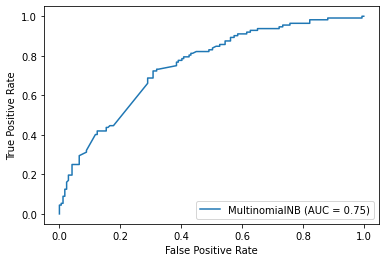

In [104]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(nb_cvec_model, X_val_cvec, y_val);

- If you have an ROC AUC of 0.5, your positive and negative populations perfectly overlap and your model is as bad as it can get.
- If you have an ROC AUC of 1, your positive and negative populations are perfectly separated and your model is as good as it can get.
- The closer your ROC AUC is to 1, the better. (1 is the maximum score.)
- If you have an ROC AUC of below 0.5, your positive and negative distributions have flipped sides. By flipping your predicted values (i.e. flipping predicted 1s and 0s), your ROC AUC will now be above 0.5.
    - Example: You have an ROC AUC of 0.2. If you change your predicted 1s to 0s and your predicted 0s to 1s, your ROC AUC will now be 0.8!

In this case, the ROC AUC is 0.75 which is quite high and shows that this model is quite good at classifying the different classes.

#### 2) Model with defaut TfidfVectorizer params for Naive Bayes classifier

In [105]:
nb_tfidf_model = nb.fit(X_train_tfidf, y_train)

In [106]:
nb_tfidf_model.score(X_train_tfidf, y_train)

0.9940688018979834

In [107]:
nb_tfidf_score = nb_tfidf_model.score(X_val_tfidf, y_val)
nb_tfidf_score

0.6334519572953736

It seems like the default multinomialnb model using Tfidfvectorizer is also overfitted.

In [108]:
nb_tfidf_pred = nb_tfidf_model.predict(X_val_tfidf)

In [109]:
nb_tfidf_cm = confusion_matrix(y_val,nb_tfidf_pred)

In [110]:
# tn,fp
# fn,tp

nb_tfidf_cm_df = pd.DataFrame(nb_tfidf_cm,
                              index=['actual r/hulu', 'actual r/netflix'],
                              columns=['pred r/hulu', 'pred r/netflix'])
nb_tfidf_cm_df

pred r/hulu  pred r/netflix
actual r/hulu             167               2
actual r/netflix          101              11

From the confusion matrix, there are  a lot of misclassification and seems to be more unbalanced than using countvectorizer. There are 2 False Positives(Type1 errors) and 101 False Negative(Type2 errors). This model seems to be better at classifying the negative class.

In [112]:
print(classification_report(y_val, nb_tfidf_pred))

              precision    recall  f1-score   support

           0       0.62      0.99      0.76       169
           1       0.85      0.10      0.18       112

    accuracy                           0.63       281
   macro avg       0.73      0.54      0.47       281
weighted avg       0.71      0.63      0.53       281



This model is bad. Since it is really bad at classifying the positive class (r/netflix), even though it seems to perform well at classifying the negative class(r/hulu). This model does not satisfy the requirements of the problem statement.

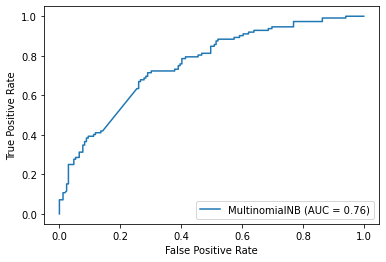

In [114]:
plot_roc_curve(nb_tfidf_model, X_val_tfidf, y_val);

The ROC AUC is 0.76 for this model, which is quite high and may be due to the good classification of the negative class(r/hulu). Although slightly better than the previous model, it does not meet the requirements since both classes are of interests.

### Logistic Regression Classifier

In [115]:
from sklearn.linear_model import LogisticRegression

In [116]:
logreg = LogisticRegression()

#### 3) Model with defaut CountVectorizer parameters for LogicRegression classifier.

In [117]:
logreg_cvec_model = logreg.fit(X_train_cvec, y_train)

In [118]:
logreg_cvec_model.score(X_train_cvec, y_train)

0.9940688018979834

In [119]:
logreg_cvec_score = logreg_cvec_model.score(X_val_cvec, y_val)
logreg_cvec_score

0.6476868327402135

It seems like the default LogisticRegression model using countvectorizer is overfitted, similar to the multinomialNB model as above.

In [120]:
logreg_cvec_pred = logreg_cvec_model.predict(X_val_cvec)

In [121]:
logreg_cvec_cm = confusion_matrix(y_val,logreg_cvec_pred)

In [122]:
# tn,fp
# fn,tp

logreg_cvec_cm_df = pd.DataFrame(logreg_cvec_cm,
                             index=['actual r/hulu', 'actual r/netflix'],
                             columns=['pred r/hulu', 'pred r/netflix'])
logreg_cvec_cm_df

pred r/hulu  pred r/netflix
actual r/hulu             163               6
actual r/netflix           93              19

From the confusion matrix, there are more misclassifications as compared to the nb_cvec_model, which is so far the better model. There are 6 False Positives(Type1 errors) and 93 False Negative(Type2 errors) in this model.

In [123]:
logreg_cvec_cr = print(classification_report(y_val, logreg_cvec_pred))

              precision    recall  f1-score   support

           0       0.64      0.96      0.77       169
           1       0.76      0.17      0.28       112

    accuracy                           0.65       281
   macro avg       0.70      0.57      0.52       281
weighted avg       0.69      0.65      0.57       281



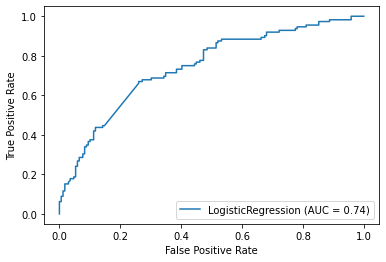

In [124]:
logreg_cvec_ROCAUC = plot_roc_curve(logreg_cvec_model, X_val_cvec, y_val);

For model logreg_cvec_model, we are seeing a similar trend in results with the nb_tfid_model.

#### 4) Model with defaut TfidfVectorizer parameters for LogicRegression classifier.

In [125]:
logreg_tfidf_model = logreg.fit(X_train_tfidf, y_train)

In [126]:
logreg_tfidf_model.score(X_train_tfidf, y_train)

0.9893238434163701

In [127]:
logreg_tfidf_score = nb_tfidf_model.score(X_val_tfidf, y_val)
logreg_tfidf_score

0.6334519572953736

It seems like the default LogisticRegression model using Tfidfvectorizer is also overfitted similar to the nb_tfidf model above. The nb_cvec model is still doing better in this.

In [128]:
logreg_tfidf_pred = logreg_tfidf_model.predict(X_val_tfidf)

In [129]:
logreg_tfidf_cm = confusion_matrix(y_val,logreg_tfidf_pred)

In [130]:
# tn,fp
# fn,tp

logreg_tfidf_cm_df = pd.DataFrame(logreg_tfidf_cm,
                              index=['actual r/hulu', 'actual r/netflix'],
                              columns=['pred r/hulu', 'pred r/netflix'])
logreg_tfidf_cm_df

pred r/hulu  pred r/netflix
actual r/hulu             168               1
actual r/netflix          104               8

In [131]:
logreg_tfidf_cr = print(classification_report(y_val, logreg_tfidf_pred))

              precision    recall  f1-score   support

           0       0.62      0.99      0.76       169
           1       0.89      0.07      0.13       112

    accuracy                           0.63       281
   macro avg       0.75      0.53      0.45       281
weighted avg       0.73      0.63      0.51       281



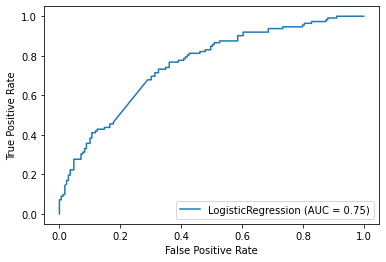

In [132]:
logreg_tfidf_ROCAUC = plot_roc_curve(logreg_tfidf_model, X_val_tfidf, y_val);

Again, there is a similar trend with the 2 models previously for model logreg_cvec_model.

Base on the 4 models trained and validated above, the nb_cvec model(naive bayes model using countvectorizer using default params) is the best model **so far** base on the requirements for the problem statement. It has the least misclassification base on the nb_cvec_cm (confusion matrix), the highest f1-score and accuracy and the best highest-balance ratio for sensitivity and specificity (recall) base on nb_cvec_cr (classification report). The misclassification for that model is also not skewed to one side.

The scoring and misclassification seem to do more badly on the positive class(r/netflix). One of the reasons could be that the data proportion for both classes are unbalanced. Another reason could be that there are too many features. Using GridSearchCV, we can then fine tune such parameters to get a better model.

### Remodel MultinomialNB and LogisticRegression using GridSearchCV

To target the problem statement, ngram_range will be set to at least bi-gram or tri-gram or both, since film/series titles which are the contents is the topic of interests and they are usually 2 to 3 words.

#### 5) First set of pipe parameters

Took some inspiration from [Stackoverflow-pipe](https://stackoverflow.com/questions/51629153/more-than-one-estimator-in-gridsearchcvsklearn), [Stackkoverflow-grid](https://stackoverflow.com/questions/34848266/typeerror-if-no-scoring-is-specified-the-estimator-passed-should-have-a-score) and [scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)

Since the dataset is imbalance between the classes, the scoring settings for the gridsearch will be the F1-score, which is the weighted average of the precision and recall.

In [144]:
# create the pipelines and params for countvectorizer and tfidfvectorizer for the multinomialNB model
pipe_1 = Pipeline([
    ('vectorizer', None),
    ('model', None)])

pipe_1_params = {
    'vectorizer': [CountVectorizer(stop_words=stops,
                                   analyzer='word',
                                   tokenizer=None,
                                   preprocessor=None),
                   TfidfVectorizer(stop_words=stops,
                                   analyzer='word',
                                   tokenizer=None,
                                   preprocessor=None)],
    'vectorizer__max_features': [10000, 15000, 20000], 
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__max_df': [0.85, 0.9, 0.95],
    'vectorizer__ngram_range': [(2,2), (2, 3)],
    'model': [MultinomialNB(),
              LogisticRegression()]
}

gs_pipe1 = GridSearchCV(pipe_1,  # objects being optimized
                        param_grid=pipe_1_params,  # parameters searched for
                        scoring='accuracy',
                        cv=5,    # 5-fold cross-validation
                        verbose=1)

gs_pipe1.fit(X_train, y_train)
gs_pipe1_model = gs_pipe1.best_estimator_
gs_pipe1_pred = gs_pipe1_model.predict(X_val)

print(f'Train accuracy: {gs_pipe1_model.score(X_train,y_train)}')
print(f'Validation accuracy: {gs_pipe1_model.score(X_val,y_val)}')
print(f'Estimated accuracy on unseen data: {gs_pipe1.best_score_}')
print(f'Best params is {gs_pipe1.best_params_}')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train accuracy: 0.9679715302491103
Validation accuracy: 0.6797153024911032
Estimated accuracy on unseen data: 0.7188222034375882
Best params is {'model': MultinomialNB(), 'vectorizer': CountVectorizer(max_df=0.85, max_features=15000, ngram_range=(2, 2),
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...}), 'vectorizer__max_df': 0.85, 'vectorizer__max_features': 15000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (2, 2)}


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  1.1min finished


The best estimator for this set of parameters in gridsearch is the MultinomialNB using CountVectorizer with 15000 features, max_df of 0.85, min_df of 1 and ngram_range of (2,2). This model is overfitted. It does better than the baseline model of 0.601, however base on validation accuracy of 0.679, the nb_cvec model performed slightly better at 0.690. The estimated accuracy score for unseen data on the other hand, is slightly better at 0.719. This is not a clear indicator that it is the best model, since both classes are of interest, the other considerations like misclassification is also a big factor.

In [150]:
gs_pipe1_cm = confusion_matrix(y_val,gs_pipe1_pred)

In [151]:
# tn,fp
# fn,tp

gs_pipe1_cm_df = pd.DataFrame(gs_pipe1_cm,
                              index=['actual r/hulu', 'actual r/netflix'],
                              columns=['pred r/hulu', 'pred r/netflix'])
gs_pipe1_cm_df

pred r/hulu  pred r/netflix
actual r/hulu             151              18
actual r/netflix           72              40

In [152]:
print(classification_report(y_val, gs_pipe1_pred))

              precision    recall  f1-score   support

           0       0.68      0.89      0.77       169
           1       0.69      0.36      0.47       112

    accuracy                           0.68       281
   macro avg       0.68      0.63      0.62       281
weighted avg       0.68      0.68      0.65       281



From the confusion matrix, there are a lot of misclassification as well. There are 18 False Positives(Type1 errors) and 72 False Negative(Type2 errors). In comparison to the nb_cvec model, its misclassification is slightly more. From the confusion matrix, precision, recall and the f1-score, we can tell that this model is better at predicting the negative class(r/hulu).

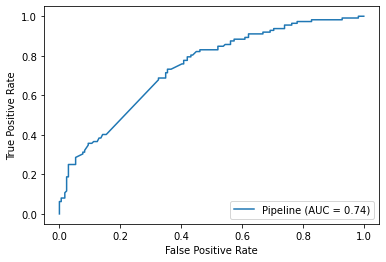

In [153]:
plot_roc_curve(gs_pipe1_model, X_val, y_val);

The ROC AUC for gs_pipe1_model is 0.74 which is quite well performing at classifying the classes. In this case more so for the negative class(r/hulu)

#### 6) Second set of pipe parameters

The max_df, min_df and ngram_range of the best params of the previous gridsearch were at the lower bound of 0.85, 1 and (2,2) respectively. However, the max_features was in the middle range. These will be tuned in the next params settings below as seen below.

In [154]:
pipe_2 = Pipeline([
    ('vectorizer', None),
    ('model', None)])

pipe_2_params = {
    'vectorizer': [CountVectorizer(stop_words=stops,
                                   analyzer='word',
                                   tokenizer=None,
                                   preprocessor=None),
                   TfidfVectorizer(stop_words=stops,
                                   analyzer='word',
                                   tokenizer=None,
                                   preprocessor=None)],
    'vectorizer__max_features': [12000, 13000, 14000, 15000, 16000, 17000],
    'vectorizer__min_df': [0, 1, 2],
    'vectorizer__max_df': [0.5, 0.6, 0.7, 0.8, 0.85, 0.9],
    'vectorizer__ngram_range': [(2, 3), (2, 2), (3, 3)],
    'model': [MultinomialNB(),
              LogisticRegression()]
}

gs_pipe2 = GridSearchCV(pipe_2,  # objects being optimized
                        param_grid=pipe_2_params,  # parameters searched for
                        scoring='accuracy',
                        cv=5,    # 5-fold cross-validation
                        verbose=1)

gs_pipe2.fit(X_train, y_train)
gs_pipe2_model = gs_pipe2.best_estimator_
gs_pipe2_pred = gs_pipe2_model.predict(X_val)

print(f'Train accuracy: {gs_pipe2_model.score(X_train,y_train)}')
print(f'Validation accuracy: {gs_pipe2_model.score(X_val,y_val)}')
print(f'Estimated accuracy on unseen data: {gs_pipe2.best_score_}')
print(f'Best params is {gs_pipe2.best_params_}')

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train accuracy: 0.9679715302491103
Validation accuracy: 0.6797153024911032
Estimated accuracy on unseen data: 0.7188222034375882
Best params is {'model': MultinomialNB(), 'vectorizer': CountVectorizer(max_df=0.5, max_features=15000, min_df=0, ngram_range=(2, 2),
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...}), 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 15000, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (2, 2)}


[Parallel(n_jobs=1)]: Done 6480 out of 6480 | elapsed:  7.7min finished


The best estimator for this set of parameters in the second gridsearch is the MultinomialNB using CountVectorizer with similar params as the above model except the max_df is 0.5 and min_df is 0. The accuracy score is similar to that of the model above.

In [155]:
gs_pipe2_cm = confusion_matrix(y_val,gs_pipe2_pred)


In [156]:
# tn,fp
# fn,tp

gs_pipe2_cm_df = pd.DataFrame(gs_pipe2_cm,
                              index=['actual r/hulu', 'actual r/netflix'],
                              columns=['pred r/hulu', 'pred r/netflix'])
gs_pipe2_cm_df

pred r/hulu  pred r/netflix
actual r/hulu             151              18
actual r/netflix           72              40

In [157]:
print(classification_report(y_val, gs_pipe2_pred))

              precision    recall  f1-score   support

           0       0.68      0.89      0.77       169
           1       0.69      0.36      0.47       112

    accuracy                           0.68       281
   macro avg       0.68      0.63      0.62       281
weighted avg       0.68      0.68      0.65       281



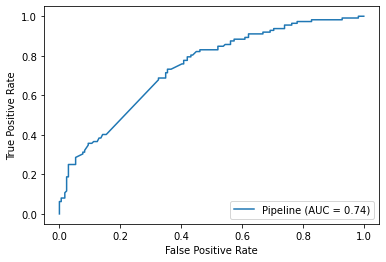

In [158]:
plot_roc_curve(gs_pipe2_model, X_val, y_val);


This model performs exactly the same even though there were a few changes to the hyperparameters.

#### 7) Third set of pipe parameters

Since the models above keeps taking the lowest of the max and min df, the next model the max_features will be reduced to see how it performs.

In [159]:
pipe_3 = Pipeline([
    ('vectorizer', None),
    ('model', None)])

pipe_3_params = {
    'vectorizer': [CountVectorizer(stop_words=stops,
                                   analyzer='word',
                                   tokenizer=None,
                                   preprocessor=None),
                   TfidfVectorizer(stop_words=stops,
                                   analyzer='word',
                                   tokenizer=None,
                                   preprocessor=None)],
    'vectorizer__max_features': [3000, 5000, 7000], # there are a total of 4154 features
    'vectorizer__min_df': [0, 1, 2],
    'vectorizer__max_df': [0.55, 0.65, 0.75, 0.85],
    'vectorizer__ngram_range': [(2, 3), (2, 2), (3, 3)],
    'model': [MultinomialNB(),
              LogisticRegression()]
}

gs_pipe3 = GridSearchCV(pipe_3,  # objects being optimized
                        param_grid=pipe_3_params,  # parameters searched for
                        scoring='accuracy',
                        cv=5,    # 5-fold cross-validation
                        verbose=1)

gs_pipe3.fit(X_train, y_train)
gs_pipe3_model = gs_pipe3.best_estimator_
gs_pipe3_pred = gs_pipe3_model.predict(X_val)

print(f'Train accuracy: {gs_pipe3_model.score(X_train,y_train)}')
print(f'Validation accuracy: {gs_pipe3_model.score(X_val,y_val)}')
print(f'Estimated accuracy on unseen data: {gs_pipe3.best_score_}')
print(f'Best params is {gs_pipe3.best_params_}')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train accuracy: 0.9039145907473309
Validation accuracy: 0.6654804270462633
Estimated accuracy on unseen data: 0.6974781628627781
Best params is {'model': MultinomialNB(), 'vectorizer': CountVectorizer(max_df=0.55, max_features=5000, min_df=0, ngram_range=(2, 2),
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...}), 'vectorizer__max_df': 0.55, 'vectorizer__max_features': 5000, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (2, 2)}


[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed:  1.9min finished


The best params are 5000 for max_features, max_df is 0.55 and min_df is 0 and ngram_range is still (2,2). The model still takes the lower bound of max_df and min_df even with the changes in other hyperparameters. In this case, the accuracy has dropped as compared to the previous model.

In [160]:
gs_pipe3_cm = confusion_matrix(y_val,gs_pipe3_pred)

In [161]:
# tn,fp
# fn,tp

gs_pipe3_cm_df = pd.DataFrame(gs_pipe3_cm,
                              index=['actual r/hulu', 'actual r/netflix'],
                              columns=['pred r/hulu', 'pred r/netflix'])
gs_pipe3_cm_df

pred r/hulu  pred r/netflix
actual r/hulu             150              19
actual r/netflix           75              37

In [162]:
print(classification_report(y_val, gs_pipe3_pred))

              precision    recall  f1-score   support

           0       0.67      0.89      0.76       169
           1       0.66      0.33      0.44       112

    accuracy                           0.67       281
   macro avg       0.66      0.61      0.60       281
weighted avg       0.66      0.67      0.63       281



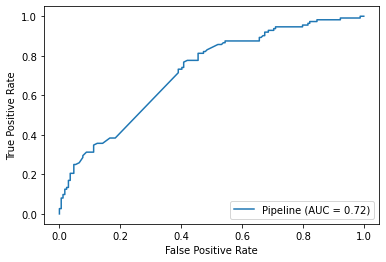

In [163]:
plot_roc_curve(gs_pipe3_model, X_val, y_val);

The number of misclassification has increased slightly comparing with the previous model. The f1-score, recall, precision and ROC AUC curve have decreased slighltly compared to the model previously. This is expected considering the accuracy for this model mentioned above decreased as well.

### Model Performance Summary

In [431]:
# Combine all results of all models into a DataFrame
Performance_Summ_df = pd.DataFrame([[0.69,0.63,0.65,0.63,0.68,0.68,0.67],
                                   [0.77,0.76,0.77,0.76,0.77,0.77,0.76],
                                   [0.52,0.18,0.28,0.13,0.47,0.47,0.44],
                                   [0.87,0.99,0.96,0.99,0.89,0.89,0.89],
                                   [0.42,0.10,0.17,0.07,0.36,0.36,0.33],
                                   [0.75,0.76,0.74,0.75,0.74,0.74,0.72],
                                   [22,2,6,1,18,18,19],
                                   [65,101,93,104,72,72,75]],
                                  index=['Accuracy','F1-Score(0)','F1-Score(1)','Recall(0)','Recall(1)','ROC_AUC',
                                        'False Positive','False Negative'],
                                  columns=['Model_1','Model_2','Model_3','Model_4','Model_5','Model_6','Model_7'])
Performance_Summ_df

Model_1  Model_2  Model_3  Model_4  Model_5  Model_6  Model_7
Accuracy           0.69     0.63     0.65     0.63     0.68     0.68     0.67
F1-Score(0)        0.77     0.76     0.77     0.76     0.77     0.77     0.76
F1-Score(1)        0.52     0.18     0.28     0.13     0.47     0.47     0.44
Recall(0)          0.87     0.99     0.96     0.99     0.89     0.89     0.89
Recall(1)          0.42     0.10     0.17     0.07     0.36     0.36     0.33
ROC_AUC            0.75     0.76     0.74     0.75     0.74     0.74     0.72
False Positive    22.00     2.00     6.00     1.00    18.00    18.00    19.00
False Negative    65.00   101.00    93.00   104.00    72.00    72.00    75.00

## Model Evaluation

### Best Model Selection

The best performing model is the 1st model, which is using the MultinomialNB model using CountVectorizer to vectorize the posts with ngram_range of (2,3) and the other hyperparameters being default.

In [171]:
print(f' The best model (model 1) has accuracy on validation test of {nb_cvec_score}')

 The best model (model 1) has accuracy on validation test of 0.6903914590747331


In [167]:
nb_cvec_cm_df

pred r/hulu  pred r/netflix
actual r/hulu             147              22
actual r/netflix           65              47

In [169]:
print(classification_report(y_val, nb_cvec_pred))

              precision    recall  f1-score   support

           0       0.69      0.87      0.77       169
           1       0.68      0.42      0.52       112

    accuracy                           0.69       281
   macro avg       0.69      0.64      0.65       281
weighted avg       0.69      0.69      0.67       281



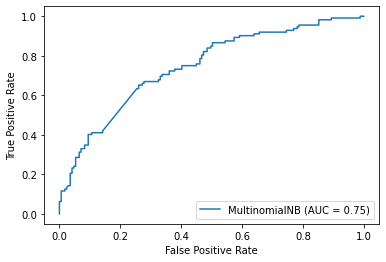

In [170]:
plot_roc_curve(nb_cvec_model, X_val_cvec, y_val);

Model 1 had the least amount of misclassification as well as the most balanced between the 2 classes, which is important since both subreddits are of interests. The f1-score, precision and recall are all the highest and most balanced of all the models as well. The ROC AUC of 0.75 is also the highest of all the models.

In [ ]:
# All model performances into DataFrame


### Top predictors

Shown below are the top 20 words with the highest probability of occuring (feature importance) in each class using the best estimator and best params of the selected best model (model 5). [Stackoverflow - feature_importance](https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes) and [Stackoverflow-steps](https://stackoverflow.com/questions/34207366/how-to-extract-the-word-features-in-trained-model-of-multinomialnb-pipeline-in-s)

In [174]:
# Best model (model 1)
print(type(nb_cvec_model))

#get the feature names
features = cvec.get_feature_names()

<class 'sklearn.naive_bayes.MultinomialNB'>


In [175]:
#get probabilities for classes
netflix_prob = np.exp(nb_cvec_model.feature_log_prob_[1,:])
hulu_prob = np.exp(nb_cvec_model.feature_log_prob_[0,:])

In [187]:
# put them into DataFrame
netflix_prob = pd.DataFrame(netflix_prob, index= features).sort_values(ascending=False, by=0)
netflix_prob.head(25)

0
queen gambit       0.000105
dolby vision       0.000063
coming december    0.000060
official trailer   0.000055
umbrella academy   0.000053
anyone know        0.000053
rick morty         0.000052
wrote crown        0.000049
fixed evangelion   0.000049
musical review     0.000049
animation cable    0.000049
coming soon        0.000049
anyone else        0.000048
aunty donna        0.000048
dash lily          0.000047
sharkboy lavagirl  0.000046
original series    0.000046
emily paris        0.000045
narcos mexico      0.000045
piece woman        0.000045
hill house         0.000044
sleep timer        0.000044
stranger thing     0.000044
need help          0.000043
social dilemma     0.000042

In [188]:
# put them into DataFrame
hulu_prob = pd.DataFrame(hulu_prob, index= features).sort_values(ascending=False,by=0)
hulu_prob.head(25)

0
anyone else           0.000143
anyone know           0.000099
next episode          0.000088
hero academia         0.000083
every time            0.000066
disney plus           0.000065
south park            0.000063
picture picture       0.000061
naruto shippuden      0.000059
gift card             0.000058
free trial            0.000057
else problem          0.000055
anyone else problem   0.000055
black friday          0.000055
else issue            0.000054
work fine             0.000054
episode start         0.000054
anime recommendation  0.000054
anyone else issue     0.000052
please help           0.000051
season episode        0.000051
live guide            0.000050
fire stick            0.000050
still paying          0.000049
fast forward          0.000048

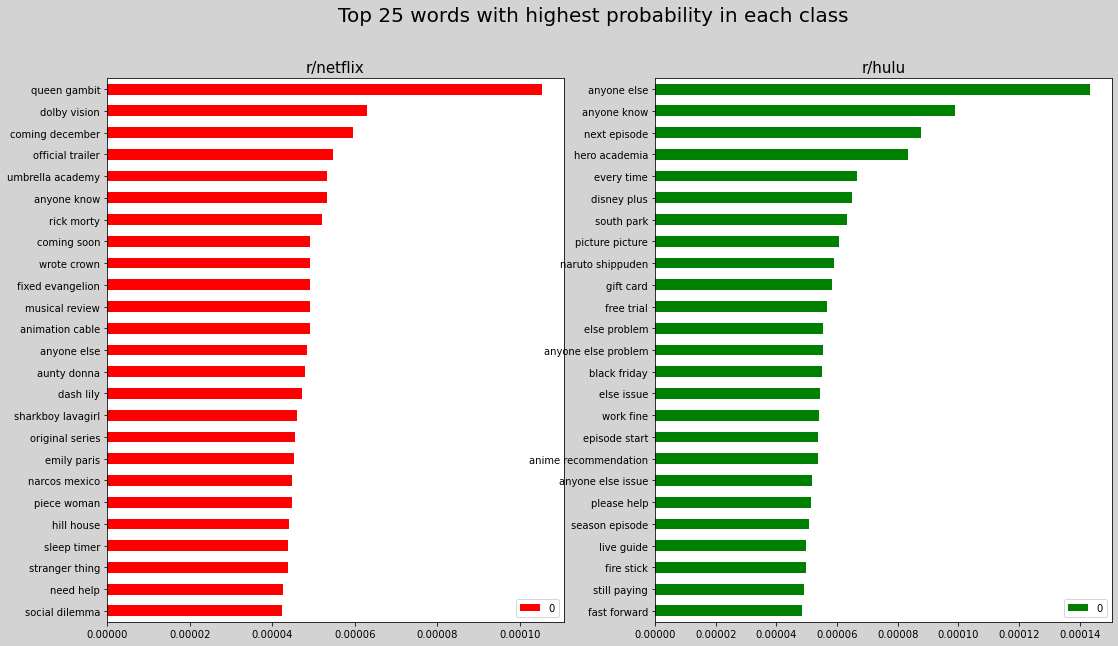

In [432]:
# plot subplots for top 20 words in the subreddits
fig, ax = plt.subplots(ncols=2, figsize=(18, 10),
                       facecolor='lightgrey')
fig.suptitle('Top 25 words with highest probability in each class', fontsize=20)

#plt subplot for r/netflix
netflix_prob.head(25).sort_values(by=0).plot(
    ax=ax[0],
    kind='barh',
    color='red',)
ax[0].tick_params(axis='y',labelsize=10)
ax[0].set_title('r/netflix', fontsize=15)

#plt subplot for r/hulu
hulu_prob.head(25).sort_values(by=0).plot(ax=ax[1],
                                      kind='barh',
                                      color='green')
ax[1].tick_params(axis='y',labelsize=10)
ax[1].set_title('r/hulu', fontsize=15)

plt.show()

### Test Evaluation of Model 1

The final model was evaluated on unseen test data set of 375 rows.

In [233]:
# unseen data was created above (took 25% of the original data before the remaining data was used to train model)
X_test = posts_df_test['all_words']
y_test = posts_df_test['target']

In [234]:
X_test.shape

(375,)

In [235]:
# Transform our unseen data with the ngram_range(2,3) and the rest are default params for CountVectorizer
X_test_cvec = pd.DataFrame(cvec.transform(X_test).toarray(),
                         columns = cvec.get_feature_names())

X_test_cvec.shape

(375, 38522)

In [237]:
# using the final model to score
nb_cvec_model.score(X_test_cvec,y_test)

0.6586666666666666

In [241]:
test_pred = nb_cvec_model.predict(X_test_cvec)

In [242]:
test_cm = confusion_matrix(y_test,test_pred)

In [243]:
# tn,fp
# fn,tp

test_cm_df = pd.DataFrame(test_cm,
                             index=['actual r/hulu', 'actual r/netflix'],
                             columns=['pred r/hulu', 'pred r/netflix'])
test_cm_df

pred r/hulu  pred r/netflix
actual r/hulu             223               2
actual r/netflix          126              24

There are alot of false negative misclassifications(126). This is expected as initially there were not as many netflix posts (negative class) to train the model with as there was for the hulu(negative class).

In [244]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.64      0.99      0.78       225
           1       0.92      0.16      0.27       150

    accuracy                           0.66       375
   macro avg       0.78      0.58      0.52       375
weighted avg       0.75      0.66      0.58       375



Similarly, the f1-score and recall shows that the model classifys hulu posts(negative class) much better.

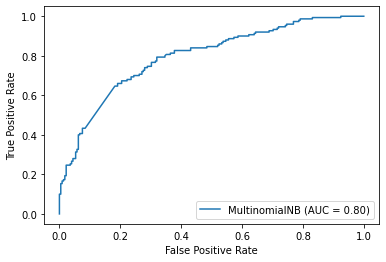

In [245]:
plot_roc_curve(nb_cvec_model, X_test_cvec, y_test);

The ROC AUC is high which could be due to the excellent classification of the negative class.

In [240]:
# compile accuracy scores into a dataframe for the final model
final_model_accuracy = pd.DataFrame([[0.601], [0.690], [0.659]],
                                    index=['Baseline', 'Validation', 'Test'],
                                    columns=['Accuracy'])
final_model_accuracy

Accuracy
Baseline       0.601
Validation     0.690
Test           0.659

Reference from [matplotlib-vline](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.vlines.html)

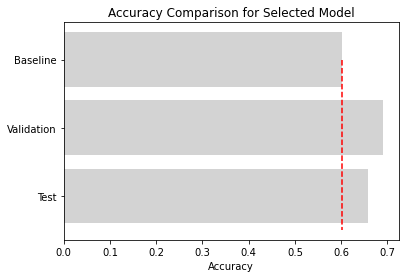

In [271]:
sns.barplot(x=final_model_accuracy.Accuracy, y=final_model_accuracy.index, orient='h',color='lightgrey')
plt.vlines(x=0.601, ymin=0, ymax=2.5, colors='red', linestyles='dashed', label='baseline')
plt.title('Accuracy Comparison for Selected Model');

In [247]:
# Create dataframe for the final model results of F1-score, recall, precision and ROC AUC for Validation and Test results
final_model_results = pd.DataFrame(
    [[0.77, 0.78], [0.52, 0.27], [0.87, 0.99], [0.42, 0.16], [0.75, 0.80],
     [22, 2], [65, 126]],
    index=[
        'F1-Score(0)', 'F1-Score(1)', 'Recall(0)', 'Recall(1)', 'ROCAUC',
        'False Positive', 'Flase Negative'
    ],
    columns=['Validation', 'Test'])

final_model_results

Validation    Test
F1-Score(0)           0.77    0.78
F1-Score(1)           0.52    0.27
Recall(0)             0.87    0.99
Recall(1)             0.42    0.16
ROCAUC                0.75    0.80
False Positive       22.00    2.00
Flase Negative       65.00  126.00

## Conclusion and Recommendation

The final model (model 1) was able to classify the unseen posts into the 2 classes, r/netflix and r/hulu, with an acceptible accuracy of 66%. This shows that the 2 subreddits are quite different but still with some similarities, which is expected since both of these subreddits are about streaming platforms for shows. Even with many similarities the model was able to classify accurately 66% of the time which is better than the basline accuracy of 60%, the reason for this may be that they have many different shows which targets different audiences. 

Netflix is known for their original series and this is supported based on the findings as one of the top words are "original series". Netflix is also know to have an extensive library for different genres, based on the top words, there are many shows titles that appear in the top words to support this. For example, we see that r/netflix top words comprise of "Queen Gambit" and "Crown" which are historical dramas and they are netflix original series. Other top words are "umbrella academy" - science fiction, "rick morty" - adult comedy, "narcos mexico" - crime drama, "hill house" and "stranger things" - supernatural/thriller/horror and "social dilemma" - documentary. 

As for Hulu, based on the top words like "naruto shippuden", "hero academia" and "anime recommendation", seems to have a wide range of anime, and the consumers seem to be very interested in it. This is one genre in which netflix is lacking in which we could improve on. [anime](https://www.quora.com/Which-has-better-anime-Hulu-or-Netflix)

Netflix should continue producing more original series since they are one of the most popular contents base on our findings. Netflix has a good range of genres to keep customers satisfied, but one thing we could do to increase our customer base is to acquire the rights to more anime shows. Acquiring the rights to shows are never easy and there are many considerations like costs, and as we are well aware that the cost to buy the rights to air the show in different geographical locations differs, we should then do some research into the cost and reward for airing them is different countries. [Investopedia](https://www.investopedia.com/articles/investing/050515/why-netflix-content-different-other-countries.asp#:~:text=Studios%20enforce%20copyright%20by%20country,different%20demands%20for%20specific%20content.&text=Because%20the%20content%20deals%20are,in%20other%20regions%20fall%20flat.)

The model has some room for improvements, especially in predicting which posts belong to r/netflix. The model shows great accuracy in classifying words into r/hulu correctly but many misclassifications happens when trying to classify the words from r/netflix. This may be due to the smaller proportion of posts scraped from r/netflix compared to r/hulu. The model can therefore be improved by increasing the corpus size by scraping more posts from r/netflix.

This model can also be used to improve product development in most companies, by looking at customer's feedback or even just comments to see what are the products that are most popular. This is a continuous process as people's taste change and there are always new products being developed all the time.